<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-(импорт-библиотек,-загрузка,-чтение-данных)" data-toc-modified-id="Подготовка-(импорт-библиотек,-загрузка,-чтение-данных)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка (импорт библиотек, загрузка, чтение данных)</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка (импорт библиотек, загрузка, чтение данных)

In [23]:
# !pip install -r requirements.txt
# при необходимости можно запустить данную команду, для установки версий библиотек,
#которые использовались при использовании данного проекта
# и с которыми не возникали конфликты

#Импорты

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords') 
nltk.download('averaged_perceptron_tagger')


#импорт контсант
RANDOM_STATE = 42


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


А также пределим ряд функций, которые будем использовать для дальнейшего обучения модели:

In [24]:
# Функция для  определения части речи слова

def get_wordnet(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [25]:
# Функция для лемматизации текста 

def lemmatize(text):
    m = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    return ' '.join([m.lemmatize(i, get_wordnet(i)) for i in text])

In [26]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

df.sample(7)

#Выведем на экран подборку из 7 записей датасета

,text,toxic
22732,Much of this page is substantially untrue. I a...,0
37477,Will do. Thanks for the note! Stay cool.,0
123430,1. Active serive and ASU are commonly used ter...,0
58865,Very funny. Censoring 95% of the criticism is ...,0
45275,"""\nSorry, I couldn't quite remember precisely ...",0
147115,"""\n\nThanks for the spelling lesson asskrackad...",1
84550,"""\n\nRfD nomination of Black -holes\nI have no...",0


Изучим датасет более подробно:

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


На данном шаге видим, что датасет состоит из 159292 записей, пропуски отсутствуютю. Типы данных соответствуют содержимому, а значит не требуют коррекции.
Названия столбцов соответствуют змеиному регистру.
Проверим наличие дубликатов в датасете и пропусков (т.к. нумерация не соответствует количеству записей в датасете)


In [28]:
df.isna().sum() #проверка пропусков

text     0
toxic    0
dtype: int64

In [29]:
df.duplicated().sum() #проверка явных дубликатов

0

Пропуски отстутствуют в датасете, явных дубликатов не обнаружно.
Неявные дубликаты проверять не буду, так как всё-таки это комментарии

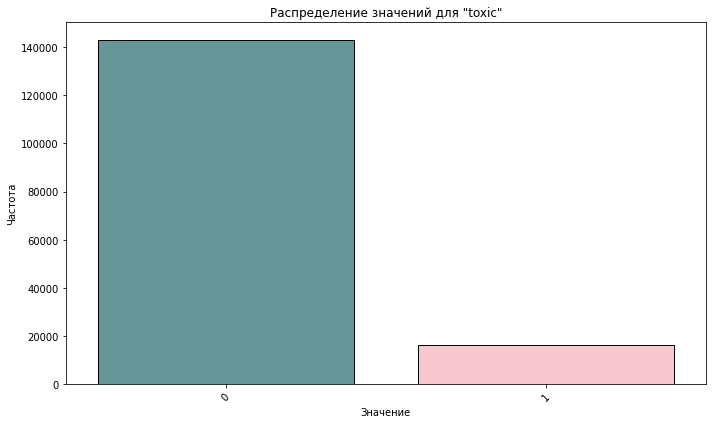

In [30]:
#построим график, чтобы отследить сбалансированность

plt.figure(figsize=(10, 6))  
sns.countplot(data=df, x='toxic',
              palette=['cadetblue', 'pink'], ec='black',
              )
plt.title('Распределение значений для "toxic"')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.tick_params(axis='x', rotation=45)  
plt.tight_layout() 
plt.show()

In [31]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Можно сделать вывод, что наблюдается дисбаланс целевой переменной. (Наверное, в данном случае, это хорошо, ведь больше позитивных комментариев :) ). 

In [32]:
tqdm.pandas()
df['lem_text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

На данном этапе провели лемматизацию датасета, а также очистили от регулярных выражений, результат сохранили в новый столбец. Выведем на экран 8 случайных записей датасета.

In [33]:
df.sample(8)

,text,toxic,lem_text
149127,"""\n\nArticle for deletion\n\nA tag has been pl...",0,article for deletion a tag have be place on jo...
136218,REDIRECT Talk:All You Need Is Luv',0,redirect talk all you need be luv'
145578,Adeel Khan \n\nLooks like you forgot to put th...,0,adeel khan look like you forgot to put the mes...
84008,"""\n\nWhat ? Cross-reference please\n\n72.129.1...",0,what cross reference please insert this in 'da...
75803,I think you're getting ahead of yourself. Tha...,0,i think you're get ahead of yourself that list...
9645,"welcome.. I see your references, and I also se...",0,welcome i see your reference and i also see th...
42865,"""\n File:IMGP4554.JPG listed for deletion \nA ...",0,file imgp jpg list for deletion a file that yo...
89709,Parli and Mace Distinction \n\nThe article att...,0,parli and mace distinction the article attempt...


**Вывод:**

- была проведена загрузка, чтение датасета, который состоит из 159292 записей.

- тип данных в столбцах корректный, наименования столбцов также соответствуют правилу хорошего стиля

- пропуски, дубликаты отсутствуют

- однако выявлен дисбаланс  целевой переменной (между негативными и позитивными комментариями), который может сказаться на дальнейшей работе модели (привести к переобучению, например)


## Обучение

In [37]:
# Выделение целевого признака и разделение выборки:
X = df.drop('toxic', axis = 1)
y = df['toxic']

# Разбиваем выборку на тренировочную и тестовую:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = RANDOM_STATE
    )

df.shape #всё в порядке в процессе разделения

(159292, 3)

In [38]:
#загружаем стоп-слоа и векторизируем текст
stop_words = stopwords.words('english') 
tf_idf_pro = TfidfVectorizer(stop_words=stop_words)
tf_idf = tf_idf_pro.fit_transform(X_train['lem_text'])


In [39]:
tf_idf_test = tf_idf_pro.transform(X_test['lem_text'])

In [40]:
#Разработаем пайплайн для обучения модели логистической регрессии

pipe_final= Pipeline([
    ('models', LogisticRegression())
])

params = [
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l2'],
        'models__C': [0.1, 1, 10, 100]
    },
    {
        'models': [LogisticRegression()],
        'models__penalty': ['none']
    },
    {
        'models': [CatBoostClassifier(random_state = RANDOM_STATE)],
        'models__iterations': [range(100, 601, 100)]
    }
] 

search = GridSearchCV(
    pipe_final, 
    params, 
    cv = 5,
    scoring='f1', 
    n_jobs=-1
)
search.fit(tf_idf, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('models', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression()],
                          'models__C': [0.1, 1, 10, 100],
                          'models__penalty': ['l2']},
                         {'models': [LogisticRegression()],
                          'models__penalty': ['none']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7f86a67f8730>],
                          'models__iterations': [range(100, 601, 100)]}],
             scoring='f1')

In [41]:
prediction = search.predict(tf_idf_test)
f1_score(y_test, prediction)

0.7753572915221313

## Выводы

Изученный датасет состоит из 159292 записей, пропуски отсутствуют. Типы данных соответствуют содержимому, а значит не требуют коррекции. Названия столбцов соответствуют змеиному регистру. Проверили наличие дубликатов в датасете и пропусков (т.к. нумерация не соответствует количеству записей в датасете): пропуски и дубликаты отсутствуют.

В ходе анализа был выявлен дисбаланс  целевой переменной (между негативными и позитивными комментариями), этот факт нужно было так же учесть при работе.

Далее была проведена лемматизация данных и очистка от регулярных выражений, после чего провели разделение выборки и обучение модели Логистической регрессии, которая показала результат f1: 0,77 - что соответствует требованиям задания (F1 должен быть не меньше 0,75)

Обученная модель может быть использована для детекции токсичных комментариев.
